# Syntaxin-Binding Protein 1 (STXBP1) and Developmental and epileptic encephalopathy 4 (DEE4)

<!-- Provide a brief overview of the syndrome and its genetic basis. Replace [Gene Name] and [Syndrome Name] with the specific gene and syndrome you are studying. -->

[Developmental and epileptic encephalopathy 4 (DEE4)](https://omim.org/entry/612164) is a neruological disorder that is typically autosomal dominant, but has been found to also occur as autosomal recessive. Onset typically happens in neonatal or infancy, showing symptoms such as many different types of seizures, developmental regression, impaired intellectual development, hypsarrhythmia, hypotonia, spastic para/quadriplegia, brain hypomyelination, cerebral atrophy, and West syndrome. The syndrome is caused by pathogenic variants in the [STXBP1](https://www.ncbi.nlm.nih.gov/gene/6812) gene.

<!-- Summarize key findings from previous studies on genotype-phenotype correlations in the syndrome. -->

One previous publications has reported candidate genotype-phenotype correlations in DEE4. 

<!-- Cite specific studies and their findings. Replace with relevant studies and findings for the specific gene and syndrome. -->

[Xian et al. (2021)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9166568/) stated that:

> "We found that individuals with PTV/dels were twice as likely to have infantile spasms, hypsarrhythmia and ataxia, and were more likely to have hypotonia and neonatal seizure onset than individuals with missense variants."


<!-- TODO: Add instructions for finding more comprehensive citations and explain the next steps in your analysis. -->
Many publications looked for correlations, but couldn't find any that presented a significant correlation. 

Therefore, we tested missense vs other variants. We also tested the first half of the gene vs the second half for correlations.


In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1


### STXBP1
We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for STXBP1.

In [2]:
gene_symbol = 'STXBP1'
mane_tx_id = 'NM_003165.6'
mane_protein_id = 'NP_003156.1'

In [4]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.21' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

print(f'Loaded {len(phenopackets)} phenopackets')
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Loaded 463 phenopackets
Individuals Processed:   4%|▍         | 19/463 [00:40<12:24,  1.68s/individuals]

Expected a result but got an Error for variant: 9_127666205_127666205_C_T
<html><body><h1>502 Bad Gateway</h1>
The server returned an invalid or incomplete response.
</body></html>



Individuals Processed:   6%|▋         | 29/463 [01:00<12:49,  1.77s/individuals]

Expected a result but got an Error for variant: 9_127665253_127665253_C_G
<html><body><h1>502 Bad Gateway</h1>
The server returned an invalid or incomplete response.
</body></html>



Individuals Processed:  20%|█▉        | 92/463 [02:31<11:19,  1.83s/individuals]

Expected a result but got an Error for variant: 9_127682554_127682555_CT_A
<html><body><h1>502 Bad Gateway</h1>
The server returned an invalid or incomplete response.
</body></html>



Individuals Processed:  27%|██▋       | 125/463 [03:19<07:02,  1.25s/individuals]

Expected a result but got an Error for variant: 9_127663332_127663333_AC_A
<html><body><h1>502 Bad Gateway</h1>
The server returned an invalid or incomplete response.
</body></html>



Individuals Processed:  30%|███       | 139/463 [03:33<06:25,  1.19s/individuals]

Expected a result but got an Error for variant: 9_127661196_127661196_T_A
<html><body><h1>502 Bad Gateway</h1>
The server returned an invalid or incomplete response.
</body></html>



Individuals Processed:  51%|█████▏    | 238/463 [05:17<03:51,  1.03s/individuals]

Expected a result but got an Error for variant: 9_127684373_127684373_A_A
{"error":"request for consequence of [A] matches reference [A]"}


Individuals Processed:  63%|██████▎   | 291/463 [06:09<02:23,  1.20individuals/s]

Expected a result but got an Error for variant: 9_127669921_127669921_A_AT
<html><body><h1>502 Bad Gateway</h1>
The server returned an invalid or incomplete response.
</body></html>



Individuals Processed:  88%|████████▊ | 407/463 [07:41<00:46,  1.20individuals/s]

Expected a result but got an Error for variant: 9_127668151_127668151_T_TA
<html><body><h1>502 Bad Gateway</h1>
The server returned an invalid or incomplete response.
</body></html>



Individuals Processed:  96%|█████████▌| 445/463 [08:09<00:15,  1.13individuals/s]

Expected a result but got an Error for variant: 9_127673256_127673256_G_T
<html><body><h1>502 Bad Gateway</h1>
The server returned an invalid or incomplete response.
</body></html>



Individuals Processed: 100%|██████████| 463/463 [08:24<00:00,  1.09s/individuals]
Loaded 463 individuals


Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #36
    phenotype-features
     warnings:
     ·#10 HP:0006919 is an obsolete identifier for Aggressive behavior. Replace HP:0006919 with the primary term ID HP:0000718
  patient #71
    phenotype-features
     warnings:

  patient #81
    variants
     errors:

      #0
       warnings:
       ·Patient STX_23708187_T23289 has an error with variant 9_127684373_127684373_A_A. Try again or remove variant form testing... Expected a result but got an Error. See log for details.
  patient #187
    phenotype-features
     warnings:
     ·#9 HP:0002355 is an obsolete identifier for Gait disturbance. Replace HP:0002355 with the primary term ID HP:0001288
  patient #198
    phenotype-features
     warnings:
     ·#5 HP:0002355 is an obsolete identifier for Gait disturbance. Replace HP:0002355 with the primary term ID HP:0001288
  patient #219
    phenotype-features
     warnings:

  patient #299
    phenotype-f

In [ ]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,230
Absent speech,HP:0001344,152
Infantile spasms,HP:0012469,143
Hypsarrhythmia,HP:0002521,120
"Intellectual disability, severe",HP:0010864,106
Inability to walk,HP:0002540,93
Generalized tonic seizure,HP:0010818,92
Multifocal epileptiform discharges,HP:0010841,86
Bilateral tonic-clonic seizure,HP:0002069,77
EEG with burst suppression,HP:0010851,75


In [ ]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)


smarcb1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
smarcb1_fig.tight_layout()

Name,Type,Coordinates,Count,Variants


Plot variant distribution with respect to the protein sequence, domains, and other features

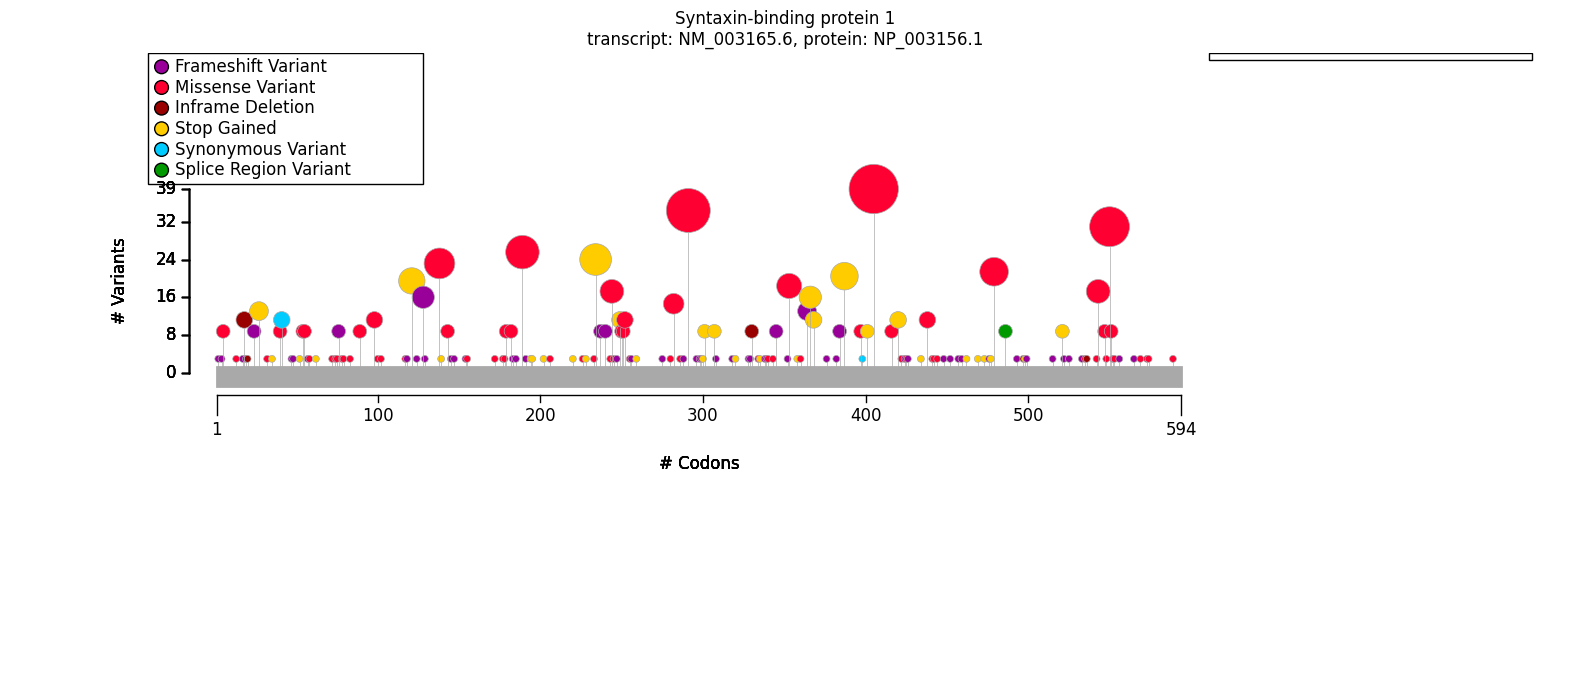

In [8]:
from gpsea.view import ProteinVisualizer

drawer = ProteinVisualizer()
_ = drawer.draw_fig(pvis=pvis)

## Allele report

In [9]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
report = viewer.process(cohort)
display(report)

Variant key,Variant (cDNA),Variant (protein),Overlapped Exons,Effects,Count
9_127675910_127675910_G_A,c.1217G>A,p.Arg406His,14,missense,19
9_127675909_127675909_C_T,c.1216C>T,p.Arg406Cys,14,missense,19
9_127668160_127668160_G_A,c.875G>A,p.Arg292His,10,missense,18
9_127682509_127682509_C_T,c.1651C>T,p.Arg551Cys,18,missense,18
9_127661192_127661192_C_T,c.416C>T,p.Pro139Leu,6,missense,12
9_127663343_127663343_C_T,c.568C>T,p.Arg190Trp,7,missense,11
9_127675855_127675855_C_T,c.1162C>T,p.Arg388Ter,14,stop gained,10
9_127678510_127678510_C_T,c.1439C>T,p.Pro480Leu,16,missense,10
9_127668159_127668159_C_T,c.874C>T,p.Arg292Cys,10,missense,10
9_127661140_127661140_C_T,c.364C>T,p.Arg122Ter,6,stop gained,9


# Configure genotype phenotype analysis

## Genotype predicate

Test Missense variants vs. the others.


In [ ]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, mono

is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
gt_predicate = autosomal_dominant(is_missense)

## Phenotype predicate

In [11]:
from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

## MTC filter, MTC correction, and statistic

In [12]:
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

## Assemble the analysis

In [13]:
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

# Execute the analysis

In [14]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

## Show MTC report

In [15]:
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
report = viewer.process(result)
display(report)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,8
HMF02,Skipping term because no genotype has more than one observed HPO count,13
HMF03,Skipping term because of a child term with the same individual counts,12
HMF04,Skipping term because all genotypes have same HPO observed proportions,158
HMF06,Skipping term with less than 7 observations (not powered for 2x2),289
HMF07,Skipping non phenotype term,4
HMF08,Skipping general term,94


## Summarize the HPO terms

In [16]:
from gpsea.view import summarize_hpo_analysis

report = summarize_hpo_analysis(hpo=hpo, result=result)
report

What is the genotype group                         No allele          \
                                                       Count Percent   
Febrile seizure (within the age range of 3 mont...       3/7     43%   
Atonic seizure [HP:0010819]                              3/7     43%   
Focal impaired awareness autonomic seizure [HP:...       0/4      0%   
Somatic sensory dysfunction [HP:0003474]                 1/2     50%   
Impaired pain sensation [HP:0007328]                     1/2     50%   
...                                                      ...     ...   
Continuous spike and waves during slow sleep [H...       2/3     67%   
Abnormal cerebellum morphology [HP:0001317]              2/4     50%   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...       3/4     75%   
EEG with parietal epileptiform discharges [HP:0...       2/3     67%   
EEG with generalized polyspikes [HP:0012001]             2/3     67%   

What is the genotype group                         Monoallelic          \
                                                         Count Percent   
Febrile seizure (within the age range of 3 mont...       15/18     83%   
Atonic seizure [HP:0010819]                              12/15     80%   
Focal impaired awareness autonomic seizure [HP:...         4/7     57%   
Somatic sensory dysfunction [HP:0003474]                   7/7    100%   
Impaired pain sensation [HP:0007328]                       6/6    100%   
...                                                        ...     ...   
Continuous spike and waves during slow sleep [H...         2/4     50%   
Abnormal cerebellum morphology [HP:0001317]                1/3     33%   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...         2/4     50%   
EEG with parietal epileptiform discharges [HP:0...         2/4     50%   
EEG with generalized polyspikes [HP:0012001]               2/4     50%   

What is the genotype group                                             \
                                                   Corrected p values   
Febrile seizure (within the age range of 3 mont...                1.0   
Atonic seizure [HP:0010819]                                       1.0   
Focal impaired awareness autonomic seizure [HP:...                1.0   
Somatic sensory dysfunction [HP:0003474]                          1.0   
Impaired pain sensation [HP:0007328]                              1.0   
...                                                               ...   
Continuous spike and waves during slow sleep [H...                1.0   
Abnormal cerebellum morphology [HP:0001317]                       1.0   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...                1.0   
EEG with parietal epileptiform discharges [HP:0...                1.0   
EEG with generalized polyspikes [HP:0012001]                      1.0   

What is the genotype group                                    
                                                    p values  
Febrile seizure (within the age range of 3 mont...  0.066362  
Atonic seizure [HP:0010819]                         0.144661  
Focal impaired awareness autonomic seizure [HP:...  0.193939  
Somatic sensory dysfunction [HP:0003474]            0.222222  
Impaired pain sensation [HP:0007328]                0.250000  
...                                                      ...  
Continuous spike and waves during slow sleep [H...  1.000000  
Abnormal cerebellum morphology [HP:0001317]         1.000000  
EEG with spike-wave complexes (<2.5 Hz) [HP:001...  1.000000  
EEG with parietal epileptiform discharges [HP:0...  1.000000  
EEG with generalized polyspikes [HP:0012001]        1.000000  

[102 rows x 6 columns]

In [17]:
from gpsea.model.genome import Region

first_half = VariantPredicates.region(Region(1,300), tx_id=mane_tx_id)
gt_half_predicate = autosomal_dominant(first_half)

In [18]:
result_half = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_half_predicate,
    pheno_predicates=pheno_predicates,
)

In [19]:
report_half = summarize_hpo_analysis(hpo=hpo, result=result_half)
report_half

What is the genotype group                         No allele          \
                                                       Count Percent   
EEG with generalized polyspikes [HP:0012001]             4/5     80%   
Focal aware seizure [HP:0002349]                         0/5      0%   
Multifocal seizures [HP:0031165]                        5/10     50%   
EEG with temporal focal spikes [HP:0012018]              8/9     89%   
EEG with temporal epileptiform discharges [HP:0...     12/13     92%   
...                                                      ...     ...   
Bilateral tonic-clonic seizure with focal onset...      9/14     64%   
Nocturnal seizures [HP:0031951]                          3/8     38%   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...       3/4     75%   
EEG with parietal epileptiform discharges [HP:0...       2/3     67%   
Focal behavior arrest seizure [HP:0011173]               2/7     29%   

What is the genotype group                         Monoallelic          \
                                                         Count Percent   
EEG with generalized polyspikes [HP:0012001]               0/2      0%   
Focal aware seizure [HP:0002349]                           2/4     50%   
Multifocal seizures [HP:0031165]                         10/12     83%   
EEG with temporal focal spikes [HP:0012018]                2/4     50%   
EEG with temporal epileptiform discharges [HP:0...         4/6     67%   
...                                                        ...     ...   
Bilateral tonic-clonic seizure with focal onset...         5/7     71%   
Nocturnal seizures [HP:0031951]                            2/4     50%   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...         2/4     50%   
EEG with parietal epileptiform discharges [HP:0...         2/4     50%   
Focal behavior arrest seizure [HP:0011173]                 0/2      0%   

What is the genotype group                                             \
                                                   Corrected p values   
EEG with generalized polyspikes [HP:0012001]                 0.992151   
Focal aware seizure [HP:0002349]                             0.992151   
Multifocal seizures [HP:0031165]                             0.992151   
EEG with temporal focal spikes [HP:0012018]                  0.992151   
EEG with temporal epileptiform discharges [HP:0...           0.992151   
...                                                               ...   
Bilateral tonic-clonic seizure with focal onset...           1.000000   
Nocturnal seizures [HP:0031951]                              1.000000   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...           1.000000   
EEG with parietal epileptiform discharges [HP:0...           1.000000   
Focal behavior arrest seizure [HP:0011173]                   1.000000   

What is the genotype group                                    
                                                    p values  
EEG with generalized polyspikes [HP:0012001]        0.142857  
Focal aware seizure [HP:0002349]                    0.166667  
Multifocal seizures [HP:0031165]                    0.171827  
EEG with temporal focal spikes [HP:0012018]         0.202797  
EEG with temporal epileptiform discharges [HP:0...  0.221878  
...                                                      ...  
Bilateral tonic-clonic seizure with focal onset...  1.000000  
Nocturnal seizures [HP:0031951]                     1.000000  
EEG with spike-wave complexes (<2.5 Hz) [HP:001...  1.000000  
EEG with parietal epileptiform discharges [HP:0...  1.000000  
Focal behavior arrest seizure [HP:0011173]          1.000000  

[100 rows x 6 columns]

In [21]:
exon_14 = VariantPredicates.exon(14, mane_tx_id)
gt_14_predicate = autosomal_dominant(exon_14)

In [22]:
result_14 = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_14_predicate,
    pheno_predicates=pheno_predicates,
)

In [23]:
report_14 = summarize_hpo_analysis(hpo=hpo, result=result_14)
report_14

What is the genotype group                         No allele          \
                                                       Count Percent   
Periventricular leukomalacia [HP:0006970]                0/7      0%   
Focal hemiclonic seizure [HP:0006813]                   4/11     36%   
Abnormal periventricular white matter morpholog...       2/9     22%   
Focal motor seizure with version [HP:0011175]            2/9     22%   
Focal impaired awareness autonomic seizure [HP:...      3/10     30%   
...                                                      ...     ...   
Hyperintensity of cerebral white matter on MRI ...      5/12     42%   
Focal cortical dysplasia type I [HP:0032047]             2/9     22%   
Focal cortical dysplasia [HP:0032046]                   4/11     36%   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...       4/7     57%   
EEG with parietal epileptiform discharges [HP:0...       3/6     50%   

What is the genotype group                         Monoallelic          \
                                                         Count Percent   
Periventricular leukomalacia [HP:0006970]                  2/3     67%   
Focal hemiclonic seizure [HP:0006813]                      3/3    100%   
Abnormal periventricular white matter morpholog...         3/4     75%   
Focal motor seizure with version [HP:0011175]              1/1    100%   
Focal impaired awareness autonomic seizure [HP:...         1/1    100%   
...                                                        ...     ...   
Hyperintensity of cerebral white matter on MRI ...         1/2     50%   
Focal cortical dysplasia type I [HP:0032047]               0/1      0%   
Focal cortical dysplasia [HP:0032046]                      0/1      0%   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...         1/1    100%   
EEG with parietal epileptiform discharges [HP:0...         1/1    100%   

What is the genotype group                                             \
                                                   Corrected p values   
Periventricular leukomalacia [HP:0006970]                         1.0   
Focal hemiclonic seizure [HP:0006813]                             1.0   
Abnormal periventricular white matter morpholog...                1.0   
Focal motor seizure with version [HP:0011175]                     1.0   
Focal impaired awareness autonomic seizure [HP:...                1.0   
...                                                               ...   
Hyperintensity of cerebral white matter on MRI ...                1.0   
Focal cortical dysplasia type I [HP:0032047]                      1.0   
Focal cortical dysplasia [HP:0032046]                             1.0   
EEG with spike-wave complexes (<2.5 Hz) [HP:001...                1.0   
EEG with parietal epileptiform discharges [HP:0...                1.0   

What is the genotype group                                    
                                                    p values  
Periventricular leukomalacia [HP:0006970]           0.066667  
Focal hemiclonic seizure [HP:0006813]               0.192308  
Abnormal periventricular white matter morpholog...  0.216783  
Focal motor seizure with version [HP:0011175]       0.300000  
Focal impaired awareness autonomic seizure [HP:...  0.363636  
...                                                      ...  
Hyperintensity of cerebral white matter on MRI ...  1.000000  
Focal cortical dysplasia type I [HP:0032047]        1.000000  
Focal cortical dysplasia [HP:0032046]               1.000000  
EEG with spike-wave complexes (<2.5 Hz) [HP:001...  1.000000  
EEG with parietal epileptiform discharges [HP:0...  1.000000  

[87 rows x 6 columns]